In [1]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(top=.9)

In [3]:
# chk: https://fred.stlouisfed.org/series/IPGMFN
# IPGMFN monthly data
industrial_production = web.DataReader('IPGMFN', 'fred', '2000', '2022-12-31').squeeze().dropna()
# NASDAQCOM daily data
# chk: https://www.nasdaq.com/market-activity/index/comp
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2022-12-31').squeeze().dropna()

In [4]:
# log transformation
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

# Differencing
nasdaq_log_diff = nasdaq_log.diff().dropna()
# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

In [5]:
industrial_production_log_diff.tail()

DATE
2022-08-01    0.025688
2022-09-01    0.040818
2022-10-01    0.025143
2022-11-01    0.009435
2022-12-01   -0.009811
Name: IPGMFN, dtype: float64

In [6]:
# ARMA vs ARIMA: ARMA MDL is ARIMA MDL's case of I=0. Thus, (2, 0, 2)
# The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.
model1 = tsa.ARIMA(endog=nasdaq_log_diff, order=(2, 0, 2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2, 1, 2)).fit()

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

In [8]:
# below should be same if model1 used ARMA MDL.
# model1.params.sort_index() == model2.params.sort_index().values
model1.params.sort_index()
# model2.params.sort_index()

ar.L1    -0.354101
ar.L2     0.197578
const     0.000156
ma.L1     0.292450
ma.L2    -0.244030
sigma2    0.000256
dtype: float64

In [9]:
# Seasonal differencing vs SARIMAX
# seasonal_order: The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2, 0, 2), seasonal_order=(0, 1, 0, 12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2, 0, 2), seasonal_order=(0, 0, 0, 12)).fit()

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [10]:
# same effect as using SARIMAX w seasonal order (0, 1, 0, 12)
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.005546,1.003347
ar.L2,-0.088012,-0.085751
ma.L1,0.137518,0.136172
ma.L2,-0.160299,-0.158429
sigma2,0.000423,0.000423


In [1]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
# to find the optimal ARMA lags
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        # print("P&Q: ", p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T - train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p, 0, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1
            print("model.params : " , model.params)
            forecast = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).replace(np.inf, np.nan).dropna())

        rmse = np.sqrt(mean_squared_error(y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse, np.mean(aic), np.mean(bic), convergence_error, stationarity_error]

NameError: name 'industrial_production_log_diff' is not defined

In [12]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [13]:
arma_results.head()

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.028771 -484.290122 -475.927647          0.0           0.0
  2  0.028780 -558.664290 -547.514323          0.0           0.0
  3  0.028128 -592.358870 -578.421411          0.0           0.0
  4  0.027001 -634.077161 -617.352211          0.0           0.0
1 0  0.025407 -662.814772 -654.452297          0.0           0.0

In [14]:
with pd.HDFStore('data/arima.h5') as store:
    store.put('arma', arma_results)

p  q
2  2    4.5
3  2    5.5
   0    7.0
   3    7.0
4  3    7.0
dtype: float64

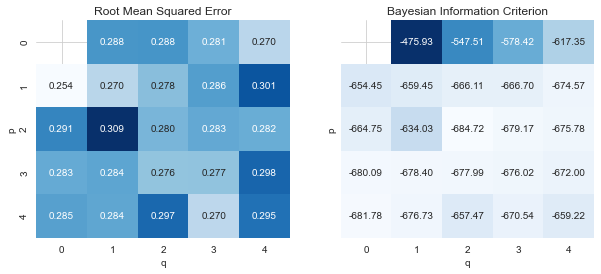

In [15]:
# goal: minimization of RMSE and BIC
arma_results.nsmallest(5, columns=['RMSE'])
arma_results.nsmallest(5, columns=['BIC'])
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE < .5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues',
            ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

In [16]:
# about unit root
# Since it's possible that the unit root that indicates the nonstationary is in a higher order AR MDL when the sum of AR coefficients is exactly equal to 1, it should "reduce 1 from the order of the AR" term and "increase the differencing order".
# Since it's possible that the unit root is in a higher order MA MDL when the sum of MA coefficients is exactly equal to 1, it should "reduce 1 from the order of the MA" term and "decrease the differencing order".
# AR or MA coefficients may have a unit root when the long-term forecasts exhibit erratic or unstable.

best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()
best_arma_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0,  best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  264
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 649.721
Date:                Thu, 20 Apr 2023   AIC                          -1287.442
Time:                        21:51:40   BIC                          -1265.986
Sample:                    01-01-2001   HQIC                         -1278.820
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.018      0.152      0.879      -0.033       0.039
ar.L1          1.0065      0.531      1.896      0.058      -0.034       2.047
ar.L2         -0.0893      0.459     -0.195      0.8

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
best_p, best_q

(2, 2)

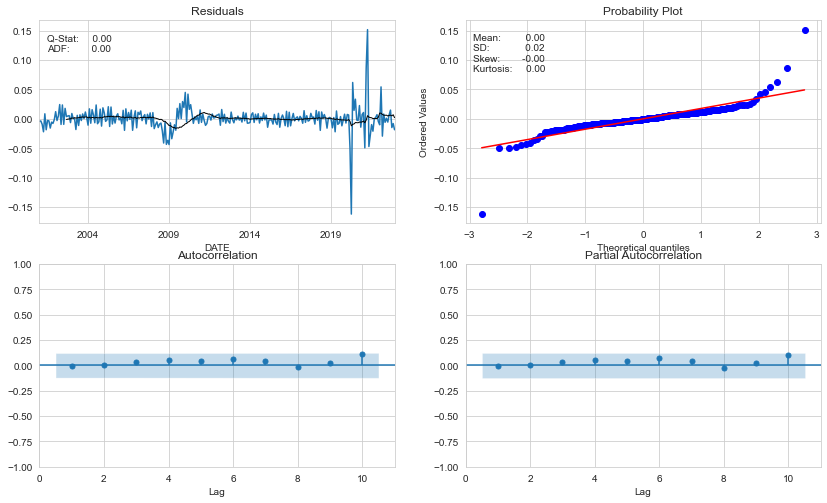

In [18]:
plot_correlogram(best_arma_model.resid)

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  264
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 704.356
Date:                              Thu, 20 Apr 2023   AIC                          -1394.713
Time:                                      21:51:42   BIC                          -1369.681
Sample:                                           0   HQIC                         -1384.654
                                              - 264                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1149      0.622      0.185      0.853      -1.104       1.334
ar.L2          0.86

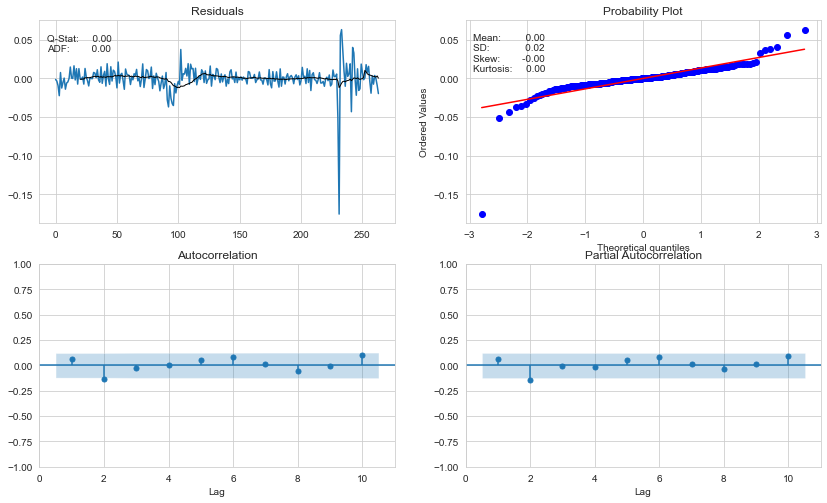

In [19]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values, order=(2, 0, 2),
                            seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])
print(sarimax_model.summary())
plot_correlogram(pd.Series(sarimax_model.resid))

In [20]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] > 0]
print("Params's lenth: ", len(params))
train_size = 120  # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
        train_set = industrial_production_log_diff.iloc[T - train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                    order=(p1, 0, q1),
                                    seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse), preds.y_true.sub(preds.y_pred).pow(2).std(), np.mean(aic),
                                 np.std(aic), np.mean(bic), np.std(bic), convergence_error, stationarity_error]

Params's lenth:  81


100%|██████████| 81/81 [1:50:42<00:00, 82.00s/it] 


In [21]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()
with pd.HDFStore('data/arima.h5') as store:
    store.put('sarimax', sarimax_results)
with pd.HDFStore('data/arima.h5') as store:
    sarimax_results = store.get('sarimax')
sarimax_results.nsmallest(5, columns='RMSE')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, (1, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          81 non-null     float64
 1   RMSE_std      81 non-null     float64
 2   AIC           81 non-null     float64
 3   AIC_std       81 non-null     float64
 4   BIC           81 non-null     float64
 5   BIC_std       81 non-null     float64
 6   convergence   81 non-null     float64
 7   stationarity  81 non-null     float64
 8   CV            81 non-null     float64
dtypes: float64(9)
memory usage: 6.7 KB


RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  1  1  2   0.023368  0.003225 -704.510120  70.873855 -684.997678  70.873855   
      0  2   0.023538  0.003224 -701.062719  68.473917 -684.337768  68.473917   
      2  1   0.023847  0.003256 -699.486078  68.309474 -679.973636  68.309474   
1  1  0  2   0.024608  0.003230 -708.139904  69.109573 -694.202446  69.109573   
2  1  0  1   0.024610  0.003325 -706.469657  70.552487 -692.532198  70.552487   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  1  1  2           1.0           0.0  0.138028  
      0  2           0.0           0.0  0.136954  
      2  1           0.0           0.0  0.136520  
1  1  0  2           0.0           0.0  0.131255  
2  1  0  1           0.0           0.0  0.135128

,,,,RMSE,RMSE_std,AIC,AIC_std,BIC,BIC_std,convergence,stationarity,CV
p1,q1,p2,q2,,,,,,,,,


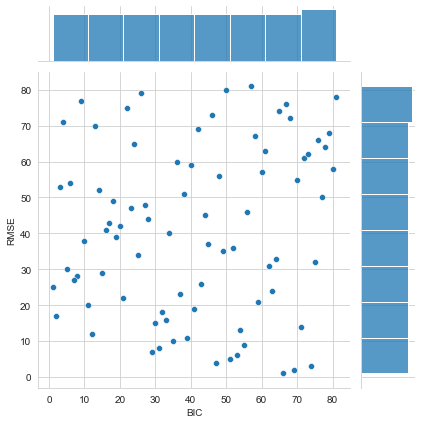

In [22]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

In [23]:
p1, q1, p2, q2 = 2, 3, 1, 2
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  264
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                 710.915
Date:                                 Thu, 20 Apr 2023   AIC                          -1403.831
Time:                                         23:42:29   BIC                          -1371.647
Sample:                                              0   HQIC                         -1390.898
                                                 - 264                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2862      0.017     16.404      0.000       0.252       0

D:\99.Dev\Python\pythonProject\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


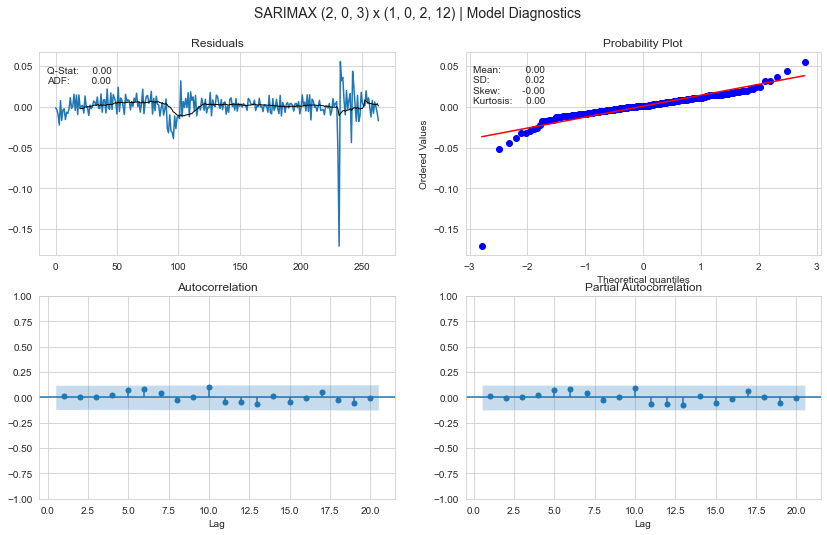

In [24]:
plot_correlogram(pd.Series(best_model.resid), lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')